In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
# import pmdarima as pm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from statsmodels.tools.eval_measures import rmse, aic

from scipy.optimize import minimize

from tqdm import tqdm_notebook

from itertools import product

In [28]:
ts_recent = pd.read_csv('data/ts_recent.csv', index_col='date_time')
ts_recent.index = pd.DatetimeIndex(ts_recent.index)
# .to_period('H')
# ts_recent.index = ts_recent.index.to_timestamp()
ts_recent.head()

,traffic_volume,weather_main,temp,clouds_all,weekday,hour,month,year
date_time,,,,,,,,
2018-08-28 14:00:00,5273,Rain,290.49,90,Tuesday,14,8,2018
2018-08-28 15:00:00,5865,Rain,290.71,90,Tuesday,15,8,2018
2018-08-28 16:00:00,6657,Rain,290.88,90,Tuesday,16,8,2018
2018-08-28 17:00:00,5716,Rain,291.01,75,Tuesday,17,8,2018
2018-08-28 18:00:00,4363,Rain,291.04,90,Tuesday,18,8,2018


### Exponential Smoothing

In [29]:
ts_recent.traffic_volume[-200:]

date_time
2018-09-22 05:00:00     960
2018-09-22 06:00:00    1635
2018-09-22 07:00:00    2445
2018-09-22 08:00:00    3415
2018-09-22 09:00:00    3770
                       ... 
2018-09-29 19:00:00    3818
2018-09-29 20:00:00    3338
2018-09-29 21:00:00    2950
2018-09-29 22:00:00    2607
2018-09-29 23:00:00    3856
Name: traffic_volume, Length: 200, dtype: int64

In [30]:
split_date = '2018-09-22'
ts_train = ts_recent.iloc[:-168].copy()
ts_test = ts_recent.iloc[-168:].copy()

In [63]:
def get_arima(data, p, q, r): 
    model = ARIMA(data, order=(p,q,r))
    fitted = model.fit()
    print(fitted.summary())
    
    plt.figure(figsize=(20,8))
    plt.plot(data[-200:])
    plt.plot(fitted.fittedvalues[-200:], color='red')
    
    if r==0:
        plt.title('AR(%d) RSS: %.4f'% (p, sum((fitted.fittedvalues).dropna()**2)), fontsize=18)
    else:
        plt.title('ARIMA(%d,%d,%d) RSS: %.4f'% (p, q, r, sum((fitted.fittedvalues).dropna()**2)), fontsize=18)

    plt.show()
    
    return fitted

C:\Users\anali\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\anali\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\anali\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:         traffic_volume   No. Observations:                  840
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -6718.620
Date:                Tue, 28 Jun 2022   AIC                          13443.239
Time:                        00:09:38   BIC                          13457.439
Sample:                             0   HQIC                         13448.682
                                - 840                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3390.9023    421.868      8.038      0.000    2564.056    4217.749
ar.L1          0.9316      0.016     59.524      0.000       0.901       0.962
sigma2      5.165e+05   1.94e+04     26.659      0.0

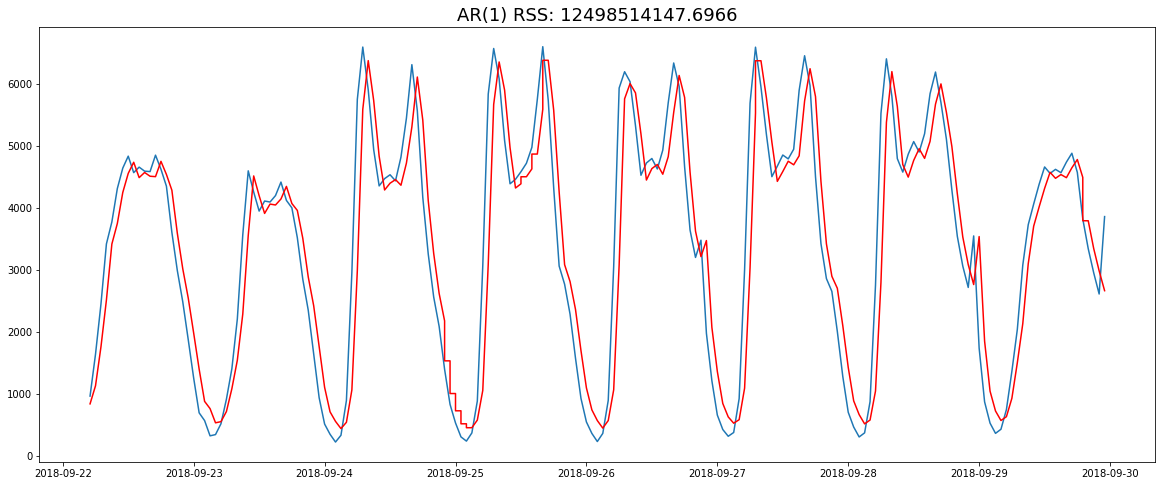

In [84]:
pd.plotting.register_matplotlib_converters()

ar2 = get_arima(ts_recent.traffic_volume, 1, 0, 0)

C:\Users\anali\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\anali\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\anali\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:         traffic_volume   No. Observations:                  840
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -6569.007
Date:                Tue, 28 Jun 2022   AIC                          13148.014
Time:                        00:18:52   BIC                          13171.681
Sample:                             0   HQIC                         13157.084
                                - 840                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3338.0179    208.844     15.983      0.000    2928.691    3747.344
ar.L1          1.6946      0.039     42.932      0.000       1.617       1.772
ar.L2         -0.7619      0.038    -20.138      0.0

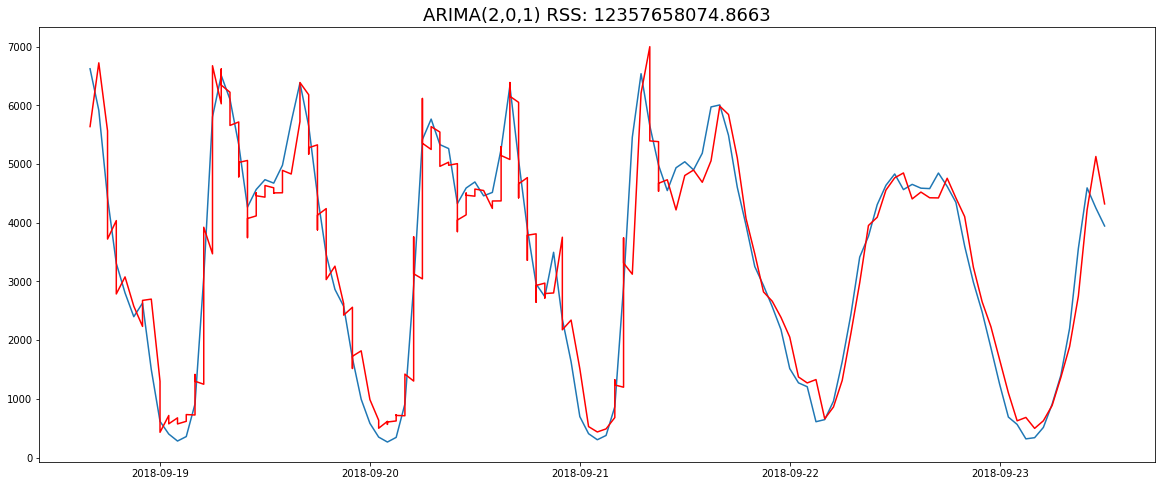

In [91]:
model = get_arima(ts_train.traffic_volume, 2, 0, 1)

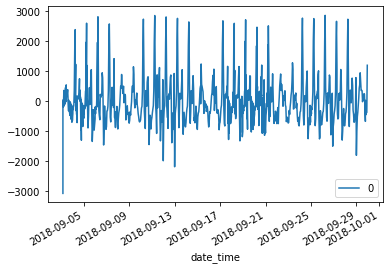

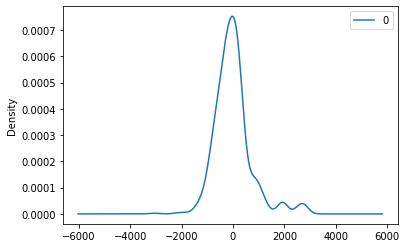

                 0
count   840.000000
mean      0.515817
std     726.404725
min   -3065.902339
25%    -420.382082
50%     -68.805995
75%     227.904606
max    2854.818314


In [85]:
# plot residual erros
residuals = pd.DataFrame(ar2.resid)
# plt.figure(figsize=(12,4))
residuals.plot()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

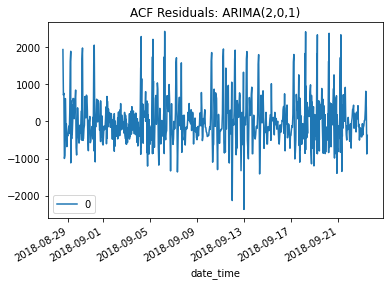

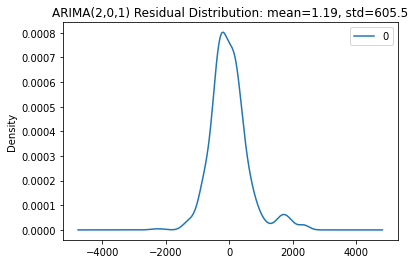

                 0
count   840.000000
mean      1.193650
std     605.520568
min   -2368.734276
25%    -366.404920
50%     -64.328970
75%     263.376340
max    2425.116521


In [123]:
# plot residual erros
residuals = pd.DataFrame(arima.resid)
# plt.title('ACF Residuals: ARIMA(2,0,1)')
residuals.plot().set_title('ACF Residuals: ARIMA(2,0,1)')
residuals.plot(kind='kde').set_title('ARIMA(2,0,1) Residual Distribution: mean=1.19, std=605.5')
plt.show()
print(residuals.describe())

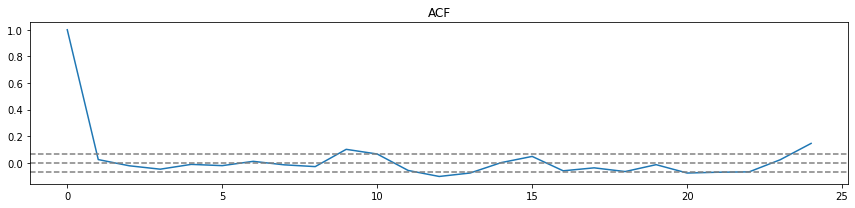

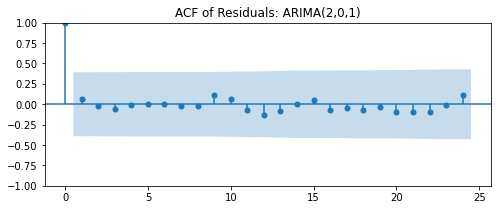

In [122]:
lag_acf = acf(residuals, nlags=24)
#Plot ACF: 
plt.figure(figsize=(12,3))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_train)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_train)),linestyle='--',color='gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,3))
plot_acf(lag_acf, ax=plt.gca(),lags=24)
plt.title('ACF of Residuals: ARIMA(2,0,1)')
plt.show()

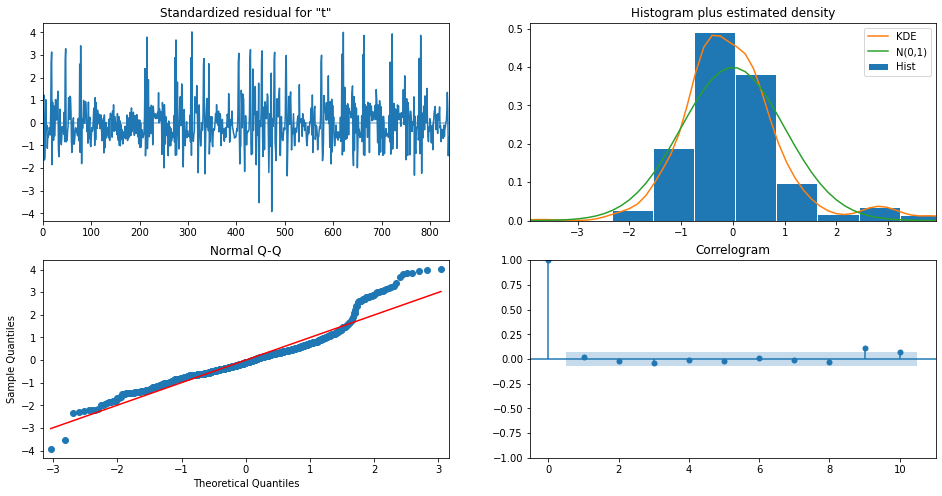

In [124]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

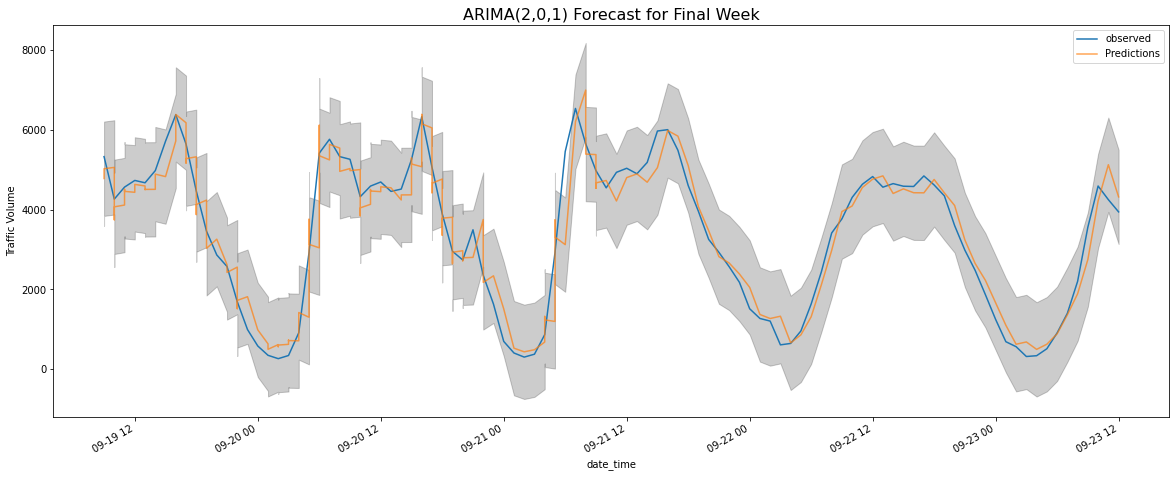

In [150]:
start_forecast = 100
pred = model.get_prediction(start=168*4)
pred_ci = pred.conf_int()

plt.figure(figsize=(20,8))
ax = ts_train[-168:].traffic_volume.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Predictions', alpha=.7).set_title('ARIMA(2,0,1) Forecast for Final Week', fontsize=16)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_ylabel('Traffic Volume')
plt.legend()

plt.show()

In [153]:
forecast = model.predict(start = len(ts_train),
                           end=len(ts_train)+len(ts_test),
                           typ='levels').rename('data ARIMA (2,0,1) forecast')

C:\Users\anali\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


<AxesSubplot:xlabel='date_time'>

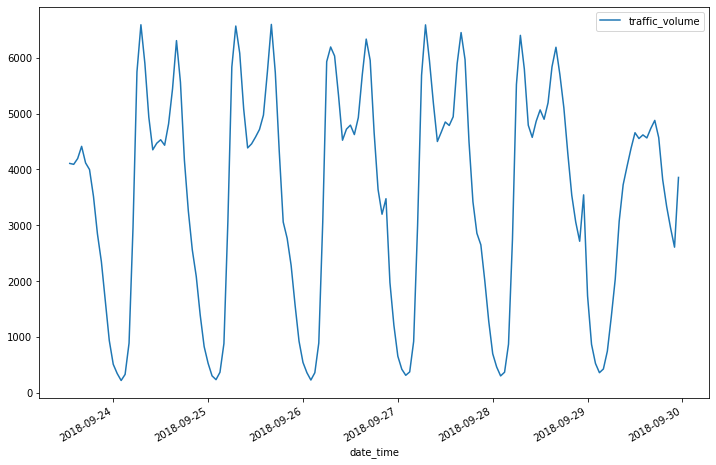

In [155]:
ts_test.traffic_volume.plot(figsize=(12,8),legend=True)
# forecast.plot(legend=True)

C:\Users\anali\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


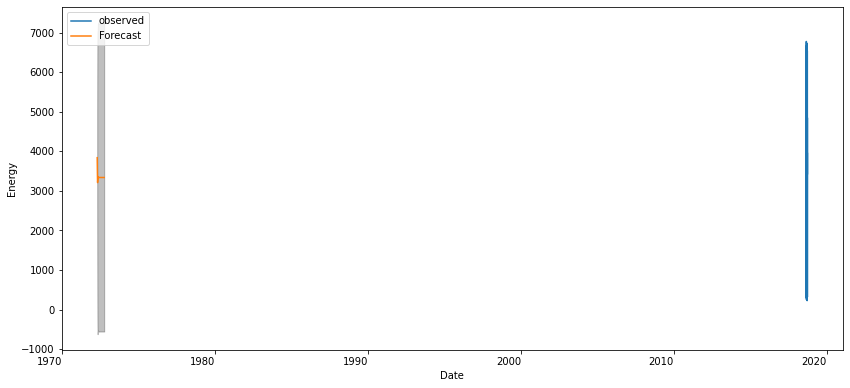

In [139]:
#%% Forecast 1y
years = 1
pred_uc = model.get_forecast(steps=168)
pred_ci = pred_uc.conf_int()
ax = ts_train.traffic_volume.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Energy')
plt.legend()
plt.show()


In [92]:
y_pred = model.predict(df=ts_test)

In [103]:
model.forecast()

C:\Users\anali\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


840    3838.329445
dtype: float64

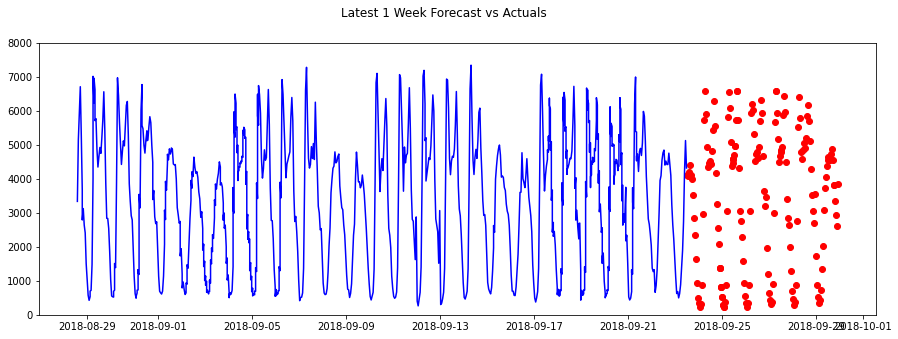

In [105]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_test.index, ts_test.traffic_volume, color='r')
plt.plot(y_pred, color='blue')
# ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))

ax.set_ylim(0, 8000)
plot = plt.suptitle('Latest 1 Week Forecast vs Actuals')

In [ ]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(ts_recent.traffic_volume, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(ts_recent.traffic_volume, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

In [15]:
# cointegration test

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cols = ['traffic_volume', 'temp', 'clouds_all']
cointegration_test(ts_recent[cols])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
traffic_volume ::  154.35    > 24.2761   =>   True
temp   ::  28.37     > 12.3212   =>   True
clouds_all ::  0.07      > 4.1296    =>   False


In [16]:
# granger causality test
maxlag=24
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(ts_recent[cols], variables = cols)  

C:\Users\anali\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\anali\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\anali\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,traffic_volume_x,temp_x,clouds_all_x
traffic_volume_y,1.000,0.0000,0.0118
temp_y,0.000,1.0000,0.0002
clouds_all_y,0.001,0.0016,1.0000


In [36]:
from pandas import Series

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
X1 = ts_recent.temp.values
X2 = ts_recent.clouds_all.values
X3 = ts_recent.traffic_volume.values
diff_temp = difference(X1)
diff_clouds = difference(X2)
diff_vol = difference(X3)

In [80]:
cols =['diff_vol', 'diff_temp', 'diff_clouds']
df=pd.concat([diff_vol,diff_temp,diff_clouds],axis=1)
df.columns = cols
df.head()

,diff_vol,diff_temp,diff_clouds
0,592,0.22,0
1,792,0.17,0
2,-941,0.13,-15
3,-1353,0.03,15
4,-957,-0.36,0


In [81]:
df = df.set_index(pd.DatetimeIndex(ts_recent.index[:-1]))

In [82]:
df.head()

,diff_vol,diff_temp,diff_clouds
date_time,,,
2018-08-28 14:00:00,592,0.22,0
2018-08-28 15:00:00,792,0.17,0
2018-08-28 16:00:00,-941,0.13,-15
2018-08-28 17:00:00,-1353,0.03,15
2018-08-28 18:00:00,-957,-0.36,0


## VAR(1)

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [32]:
ts_recent.head()

,traffic_volume,weather_main,temp,clouds_all,weekday,hour,month,year,diff_temp,diff_clouds,diff_vol
date_time,,,,,,,,,,,
2018-08-28 14:00:00,5273,Rain,290.49,90,Tuesday,14,8,2018,NaN,NaN,NaN
2018-08-28 15:00:00,5865,Rain,290.71,90,Tuesday,15,8,2018,NaN,NaN,NaN
2018-08-28 16:00:00,6657,Rain,290.88,90,Tuesday,16,8,2018,NaN,NaN,NaN
2018-08-28 17:00:00,5716,Rain,291.01,75,Tuesday,17,8,2018,NaN,NaN,NaN
2018-08-28 18:00:00,4363,Rain,291.04,90,Tuesday,18,8,2018,NaN,NaN,NaN


In [83]:
df_train,df_test = df.iloc[:-168].copy(), df.iloc[-168:].copy()

model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9,10]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  18.180212103169563
BIC :  18.247959379071453
FPE :  78625947.25588271
HQIC:  18.206180401312206 

Lag Order = 2
AIC :  18.10575420601086
BIC :  18.224423627134254
FPE :  72984334.19083884
HQIC:  18.15124412010119 

Lag Order = 3
AIC :  18.023255924018564
BIC :  18.192943553674716
FPE :  67205076.60424662
HQIC:  18.088306499427002 

Lag Order = 4
AIC :  18.00089149989301
BIC :  18.221693700215386
FPE :  65719027.17468578
HQIC:  18.085541906458673 

Lag Order = 5
AIC :  17.993099138703403
BIC :  18.265112571932683
FPE :  65209339.70708498
HQIC:  18.097388671276224 

Lag Order = 6
AIC :  17.980505658373286
BIC :  18.303827288149407
FPE :  64393895.676943704
HQIC:  18.104473737359122 

Lag Order = 7
AIC :  17.959301139530186
BIC :  18.334028232191486
FPE :  63043664.51004183
HQIC:  18.102987311438948 

Lag Order = 8
AIC :  17.923450348930114
BIC :  18.349680474819596
FPE :  60824597.828810334
HQIC:  18.086894286926913 

Lag Order = 9
AIC :  17.90419693067865
BIC :  18.

C:\Users\anali\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [84]:
x = model.select_order(maxlags=10)
x.summary()

,AIC,BIC,FPE,HQIC
0,19.25,19.27,2.301e+08,19.26
1,18.20,18.27,8.003e+07,18.22
2,18.12,18.24,7.407e+07,18.17
3,18.04,18.21*,6.833e+07,18.11
4,18.02,18.24,6.680e+07,18.10
5,18.01,18.28,6.609e+07,18.11
6,17.99,18.32,6.515e+07,18.12
7,17.97,18.34,6.359e+07,18.11
8,17.93,18.36,6.114e+07,18.09
9,17.91,18.39,5.985e+07,18.09


In [97]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, Jun, 2022
Time:                     17:30:40
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    18.1929
Nobs:                     836.000    HQIC:                   18.0883
Log likelihood:          -11062.4    FPE:                6.72051e+07
AIC:                      18.0233    Det(Omega_mle):     6.48500e+07
--------------------------------------------------------------------
Results for equation diff_vol
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -1.045704        21.922027           -0.048           0.962
L1.diff_vol            0.371216         0.034713           10.694           0.000
L1.diff_temp          83.803243        37.789093     

In [98]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input

3


array([[1032.  ,    2.26,  -19.  ],
       [-342.  ,    2.41,    0.  ],
       [-307.  ,    1.69,   74.  ]])

In [99]:
df.columns

Index(['diff_vol', 'diff_temp', 'diff_clouds'], dtype='object')

In [100]:
fc = model_fitted.forecast(y=forecast_input, steps=len(ts_test))
df_forecast = pd.DataFrame(fc, index=df_test.index, columns=df.columns)
df_forecast

,diff_vol,diff_temp,diff_clouds
date_time,,,
2018-09-23 12:00:00,-50.246687,1.287593,-25.760426
2018-09-23 13:00:00,-24.632005,0.615343,-7.695865
2018-09-23 14:00:00,8.493974,0.267384,5.447236
2018-09-23 15:00:00,-21.555296,0.036642,4.355294
2018-09-23 16:00:00,-21.876254,-0.054830,-2.004957
...,...,...,...
2018-09-29 19:00:00,-1.490220,0.004306,-0.038565
2018-09-29 19:00:00,-1.490220,0.004306,-0.038565
2018-09-29 20:00:00,-1.490220,0.004306,-0.038565


In [101]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [102]:
df_results = invert_transformation(df_train, df_forecast) 
df_results.loc[:, ['diff_vol', 'diff_temp', 'diff_clouds']]

,diff_vol,diff_temp,diff_clouds
date_time,,,
2018-09-23 12:00:00,-50.246687,1.287593,-25.760426
2018-09-23 13:00:00,-24.632005,0.615343,-7.695865
2018-09-23 14:00:00,8.493974,0.267384,5.447236
2018-09-23 15:00:00,-21.555296,0.036642,4.355294
2018-09-23 16:00:00,-21.876254,-0.054830,-2.004957
...,...,...,...
2018-09-29 19:00:00,-1.490220,0.004306,-0.038565
2018-09-29 19:00:00,-1.490220,0.004306,-0.038565
2018-09-29 20:00:00,-1.490220,0.004306,-0.038565


In [108]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def adjust(val, length= 6): return str(val).ljust(length)

print('Forecast Accuracy of: traffic volume')
accuracy_prod = forecast_accuracy(df_results['diff_vol'].values, df_test['diff_vol'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

# print('\nForecast Accuracy of: pgnp')
# accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
# for k, v in accuracy_prod.items():
#     print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: traffic volume
mape   :  inf
me     :  -2.002
mae    :  578.9203
mpe    :  -inf
rmse   :  828.554
corr   :  0.037
minmax :  inf


C:\Users\anali\AppData\Local\Temp/ipykernel_14700/91655277.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\anali\AppData\Local\Temp/ipykernel_14700/91655277.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\anali\AppData\Local\Temp/ipykernel_14700/91655277.py:13: RuntimeWarning: divide by zero encountered in true_divide
  minmax = 1 - np.mean(mins/maxs)             # minmax


In [105]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [106]:
df_results = invert_transformation(df_train, df_forecast)        


KeyError: 'diff_vol_1d'

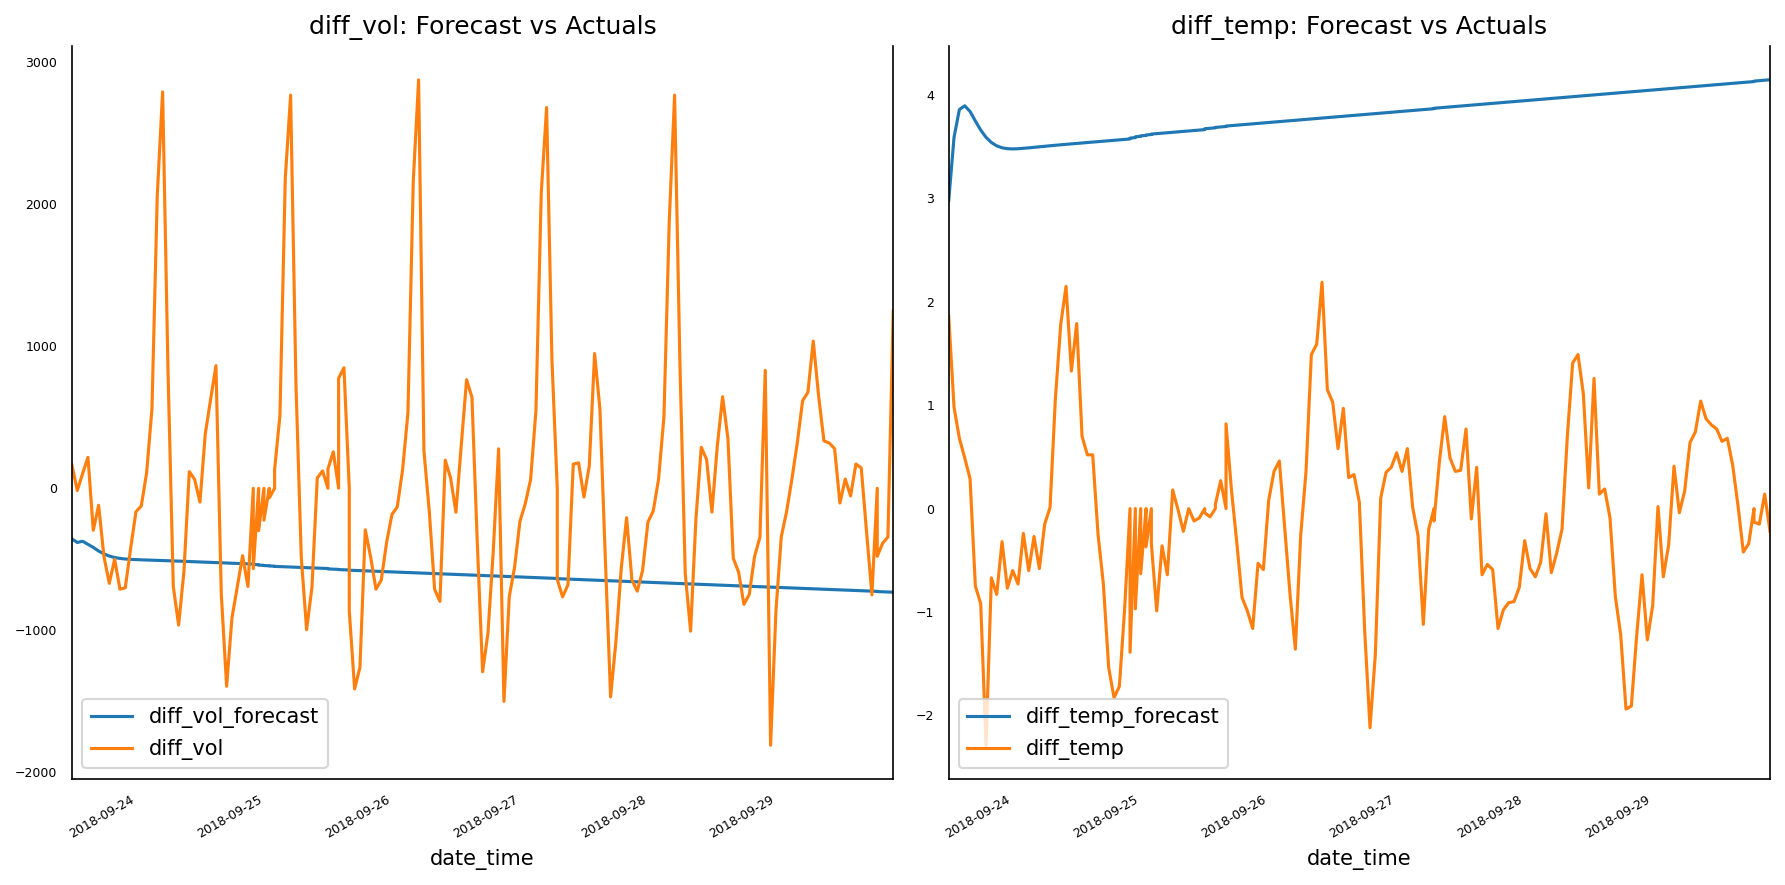

In [103]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(12,6))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-168:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();